In [15]:
!ls test/local_node/state

import pickle
from pandas import DataFrame
import numpy as np
import math

state_df = pickle.load(open("test/local_node/state/0x85Cb0baB616Fe88a89A35080516a8928F38B518b_df.pkl", "rb"))
state_df.columns.values

0x85Cb0baB616Fe88a89A35080516a8928F38B518b_df.csv
0x85Cb0baB616Fe88a89A35080516a8928F38B518b_df.pkl
test-state.json


array(['sender', 'to', 'amount0In', 'amount1In', 'amount0Out',
       'amount1Out', 'block', 'reserve0', 'reserve1'], dtype=object)

# Construct Oracles

Our dataframe starts with swaps and reserves prior to swaps. Using this data we crunch some numbers to build build various oraclse. Since we do not have time which our scanner does not grab, we use blocks thus BWAP rather than TWAP. If every block was 12 seconds exactly, this would be the same, but since that is not the case, there are some minor erorrs. 

In [23]:
# additive TWAP
state_df["cumsum_x_per_y"] = (state_df['reserve0'] / state_df['reserve1']).cumsum()
state_df["cumsum_y_per_x"] = (state_df['reserve1'] / state_df['reserve0']).cumsum()

state_df["twap_30_x_per_y"] = (state_df["cumsum_x_per_y"] - state_df["cumsum_x_per_y"].shift(periods=150)) / 150
state_df["twap_30_y_per_x"] = (state_df["cumsum_y_per_x"] - state_df["cumsum_y_per_x"].shift(periods=150)) / 150
state_df["twap_60_x_per_y"] = (state_df["cumsum_x_per_y"] - state_df["cumsum_x_per_y"].shift(periods=300)) / 300
state_df["twap_60_y_per_x"] = (state_df["cumsum_y_per_x"] - state_df["cumsum_y_per_x"].shift(periods=300)) / 300
# multiplicative TWAP
state_df["tick_sum_x_per_y"] = (np.log((state_df['reserve0'] / state_df['reserve1']).astype(float)) /
                                math.log(1.0001)).cumsum()

state_df["mult_twap_30_x_per_y"] = np.power(
    1.0001, (state_df["tick_sum_x_per_y"] - state_df["tick_sum_x_per_y"].shift(150)) / 150
)
state_df["mult_twap_60_x_per_y"] = np.power(
    1.0001, (state_df["tick_sum_x_per_y"] - state_df["tick_sum_x_per_y"].shift(300)) / 300
)

# VWAP
state_df["cumsum_x_in"] = state_df["amount0In"].cumsum()
state_df["cumsum_y_out"] = state_df["amount1Out"].cumsum()
state_df["cumsum_y_in"] = state_df["amount1In"].cumsum()
state_df["cumsum_x_out"] = state_df["amount0Out"].cumsum()

state_df["vwap_30_x_per_y"] = (
        state_df["cumsum_x_in"] + state_df["cumsum_x_out"] -
        (state_df["cumsum_x_in"] + state_df["cumsum_x_out"]).shift(150)) / (
        state_df["cumsum_y_in"] + state_df["cumsum_y_out"] -
        (state_df["cumsum_y_in"] + state_df["cumsum_y_out"]).shift(150))

# 30 Minute Oracle Comparison

In [35]:
state_df.iloc[150:][['twap_30_x_per_y', 'mult_twap_30_x_per_y', 'vwap_30_x_per_y']].head()

,twap_30_x_per_y,mult_twap_30_x_per_y,vwap_30_x_per_y
150,119.785389,94.169711,123.08407
151,120.271365,95.825643,122.553189
152,120.880683,97.624006,122.425401
153,121.413569,99.490043,122.519224
154,121.927444,101.502074,123.490798


In [34]:
average_price_df = state_df.iloc[150:][['twap_30_x_per_y', 'mult_twap_30_x_per_y', 'vwap_30_x_per_y']]
average_price_df["price_shifted_forward"] = (state_df['reserve0'] / state_df['reserve1']).shift(periods=75)

In [ ]:
##

<AxesSubplot: >

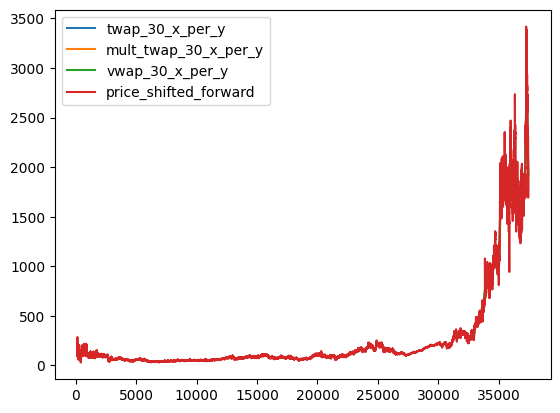

In [30]:
average_price_df.plot()

<AxesSubplot: >

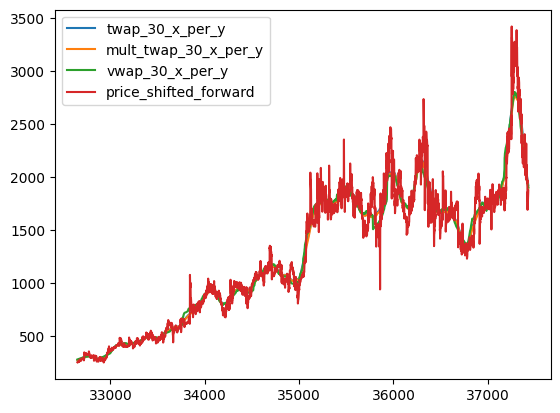

In [31]:
average_price_df.iloc[32500:].plot()

<AxesSubplot: >

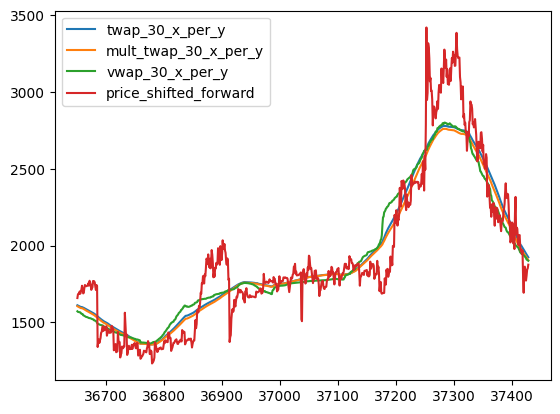

In [33]:
average_price_df.iloc[36500:].plot()